### Applied Machine Learning
# Homework 3
Shuai Hao (sh3831), Eugene M. Joseph (emj2152)

## Predict the price of a used vehicle
[This dataset](https://www.kaggle.com/austinreese/craigslist-carstrucks-data) includes every used vehicle entry within the United States on [Craigslist](https://www.craigslist.org/about/sites). The latest data were scraped in January 2020. 



In [1]:
!pip install category_encoders

In [2]:
!pip install --user --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /Users/emjoseph/Library/Python/3.8/lib/python/site-packages (0.22.2.post1)


In [3]:
%matplotlib inline

In [129]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import sample
import seaborn as sns
from scipy.stats import randint
from scipy.cluster import hierarchy
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer, enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer 
from sklearn.preprocessing import scale
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression, RFECV

In [5]:
df = pd.read_csv("vehicles.csv")

In [6]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


## Task 1: Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two
arrays X and y). What features are relevant for the prediction task?
Are there any features that should be excluded because they leak the target information?
Show visualizations or statistics to support your selection.
You are not required to use the description column, but you can try to come up with relevant
features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later
in the class.

We'll start of by exploring various properties of the fields in our dataframe to better understand them

In [7]:
all_rows = len(df['id'])

In [8]:
df['type'].unique()

array(['hatchback', nan, 'pickup', 'SUV', 'sedan', 'truck', 'wagon',
       'van', 'coupe', 'convertible', 'other', 'offroad', 'mini-van',
       'bus'], dtype=object)

In [9]:
df['price'].isna().sum()/all_rows

0.0

In [10]:
df['county'].isna().sum()/all_rows

1.0

In [11]:
df['description_len'] = [len(str(text)) if text else 0 for text in df['description']]

In [12]:
df['description_len']

0         1345
1         5664
2         7759
3         5743
4         5212
          ... 
509572    8147
509573    8914
509574    4744
509575    1356
509576    5180
Name: description_len, Length: 509577, dtype: int64

Here are some plots of the distributions of the continuous variables and the target

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


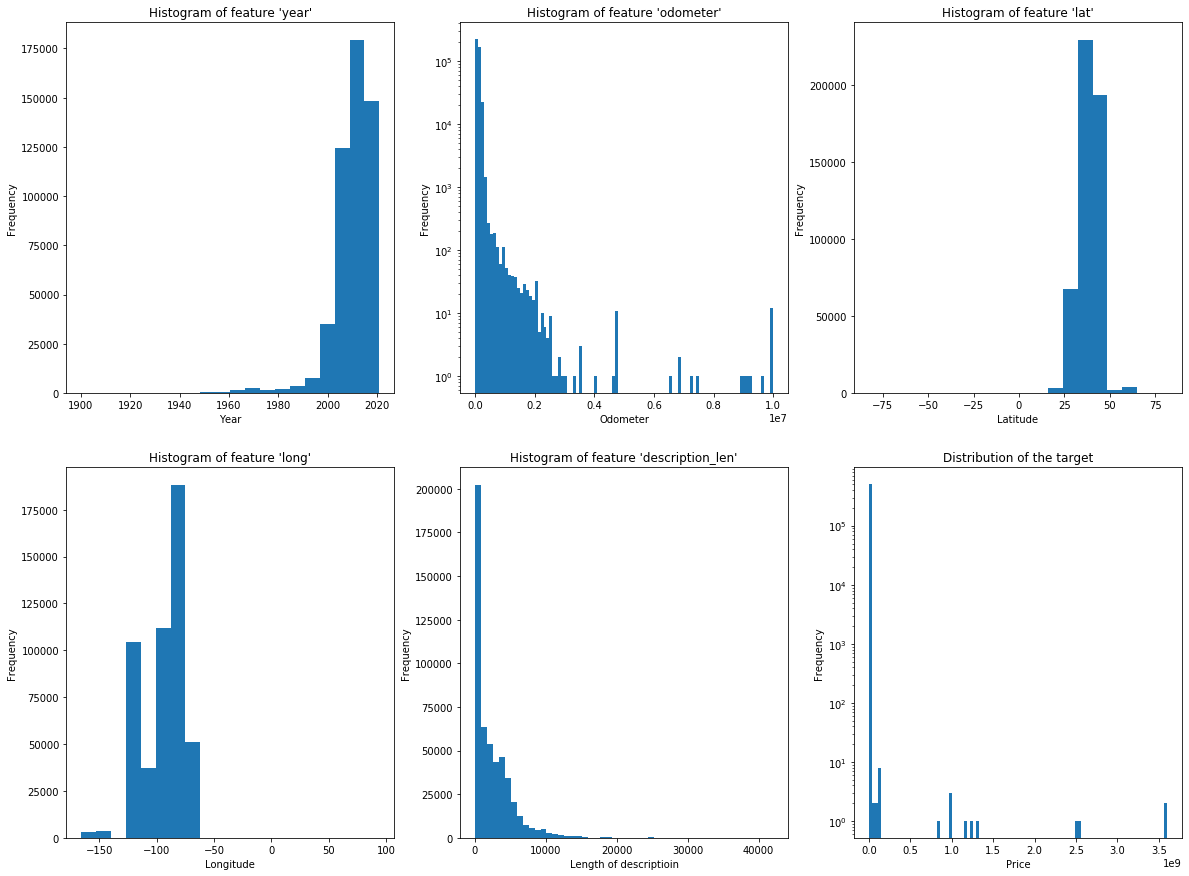

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))
ax[0][0].hist(x = df["year"], bins=20)
ax[0][0].set_xlabel("Year")
ax[0][0].set_ylabel("Frequency")
ax[0][0].title.set_text("Histogram of feature 'year'")
ax[0][1].hist(x = df["odometer"], bins=100)
ax[0][1].set_xlabel("Odometer")
ax[0][1].set_ylabel("Frequency")
ax[0][1].set_yscale('log')
ax[0][1].title.set_text("Histogram of feature 'odometer'")
ax[0][2].hist(x = df["lat"], bins=20)
ax[0][2].set_xlabel("Latitude")
ax[0][2].set_ylabel("Frequency")
ax[0][2].title.set_text("Histogram of feature 'lat'")
ax[1][0].hist(x = df["long"], bins=20)
ax[1][0].set_xlabel("Longitude")
ax[1][0].set_ylabel("Frequency")
ax[1][0].title.set_text("Histogram of feature 'long'")
ax[1][1].hist(x = df["description_len"], bins=50)
ax[1][1].set_xlabel("Length of descriptioin")
ax[1][1].set_ylabel("Frequency")
ax[1][1].title.set_text("Histogram of feature 'description_len'")
ax[1][2].hist(x = df["price"], bins=100)
ax[1][2].set_xlabel("Price")
ax[1][2].set_ylabel("Frequency")
ax[1][2].set_yscale('log')
ax[1][2].title.set_text("Distribution of the target")
plt.show()

In [14]:
continuous_cols = df.dtypes != 'object'
continuous = df.columns[continuous_cols].to_list()

categorical_cols = df.dtypes == 'object'
categorical = df.columns[categorical_cols].to_list()

Now let's observe plots of the continuous features vs the target to better understand their relation

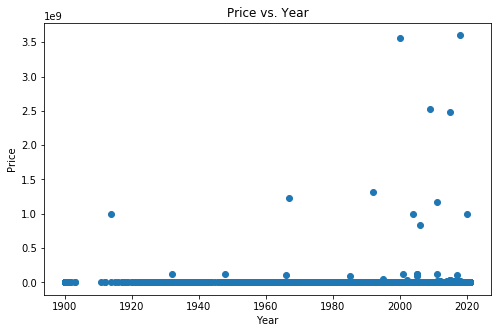

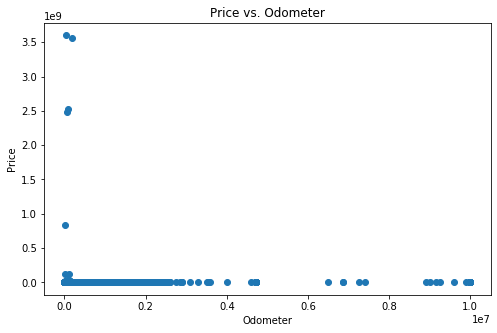

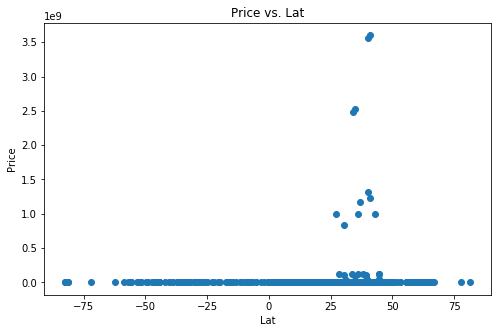

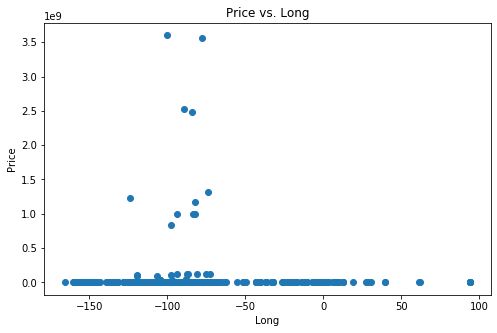

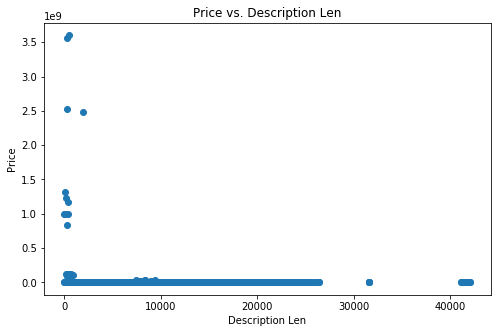

In [15]:
continuous.remove('price')
continuous.remove('county')
continuous.remove('id')
for continuous_var in continuous:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    pretty_feature_name = continuous_var.title().replace("_", " ")
    ax.scatter(df[continuous_var], df['price'])
    ax.set_ylabel('Price')
    ax.set_xlabel(pretty_feature_name)
    ax.set_title('Price vs. ' + pretty_feature_name)

There are several outliers obscuring the plots so lets try plotting again on a log scale

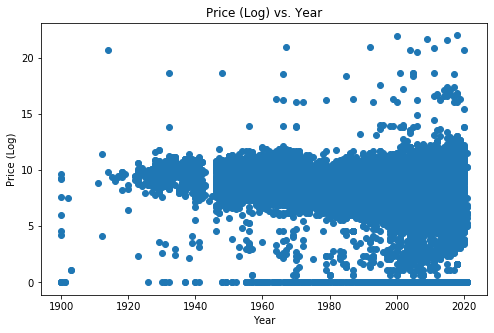

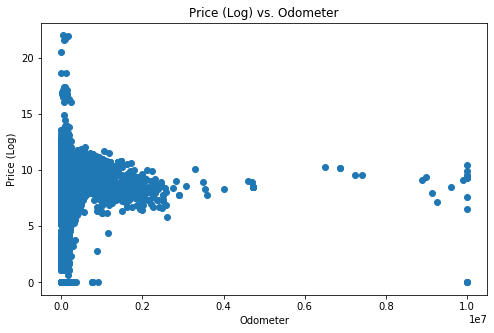

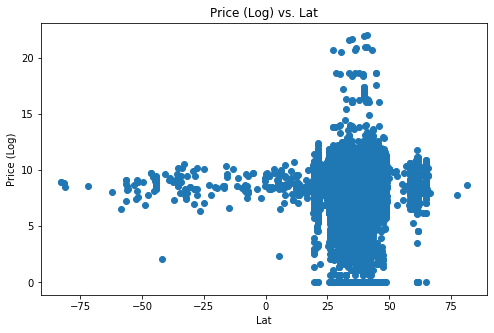

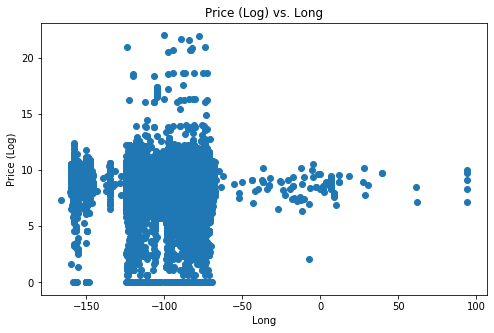

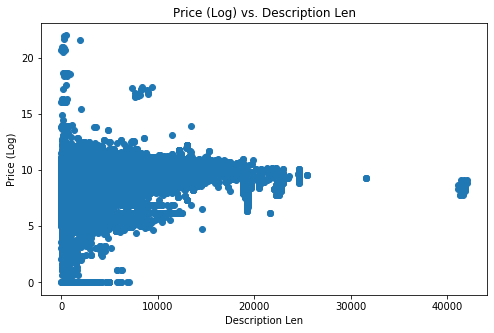

In [16]:
df_vis = df[df['price'] > 0]
for continuous_var in continuous:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    pretty_feature_name = continuous_var.title().replace("_", " ")
    ax.scatter(df_vis[continuous_var], np.log(df_vis['price']))
    ax.set_ylabel('Price (Log)')
    ax.set_xlabel(pretty_feature_name)
    ax.set_title('Price (Log) vs. ' + pretty_feature_name)

Now let's get a sense for the location data with a plot as well

Text(0.5, 1.0, 'Long vs. Lat (Log(Price) in Color Bar)')

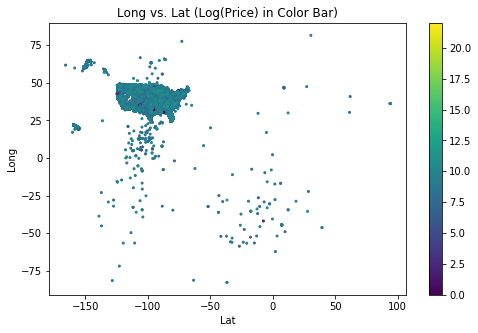

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
scatter = ax.scatter(df_vis['long'], df_vis['lat'], c=np.log(df_vis['price']), s=4)
ax.set_ylabel('Long')
ax.set_xlabel('Lat')
plt.colorbar(scatter)
ax.set_title('Long vs. Lat (Log(Price) in Color Bar)')

From this plot we can see that most of the long/lat points are located in the contiguous United States but there seem to be several outside the country perhaps in territories like Alaska or islands states like Hawaii.It may be wise to remove this data in it's current form from our models to start and find a better way to use these features than individually.

Let's get a quick sense for which columns contain null/empty/missing values

In [18]:
print("Percentage of missing values per column (%):")
print(df.isna().sum()/len(df)*100)

Percentage of missing values per column (%):
id                   0.000000
url                  0.000000
region               0.000000
region_url           0.000000
price                0.000000
year                 0.299660
manufacturer         4.467235
model                1.567771
condition           45.515006
cylinders           39.186031
fuel                 0.782021
odometer            18.117772
title_status         0.600891
transmission         0.729821
vin                 40.705330
drive               28.286795
size                67.115078
type                27.774213
paint_color         32.322102
image_url            0.002747
description          0.003140
county             100.000000
state                0.000000
lat                  2.019714
long                 2.019714
description_len      0.000000
dtype: float64


Let's also quickly get a sense for the number of unique values in the categorical columns to determine the optimal encoding approach

In [19]:
print("Number of unique entries per categorical column")
df[categorical].nunique()

Number of unique entries per categorical column


url             509577
region             403
region_url         413
manufacturer        43
model            35852
condition            6
cylinders            8
fuel                 5
title_status         6
transmission         3
vin             180145
drive                3
size                 4
type                13
paint_color         12
image_url       349468
description     427803
state               51
dtype: int64

The model and region columns both contain a large number of categorical values. We should probably use target encoding to handle them.

**Target:**

price

**Continuous features:**

year, odometer, **description_len** (length of description, custom feature)

**Categorical features:**

region, manufacturer, model, condition, cylinders, fuel, title_status, transmission, drive, size, type, paint_color, state

**Dropped features:**
- **id:** Unique id of each listing. The assigned id won't affect the price of a used car.
- **url:** URL of each listing. The listing's URL won't affect the price of a used car.
- **region_url:** URL of the region of the listing. The region's URL is degenrate to the feature "region."
- **vin:** Vehicle Identification Number of the car. The id number of the car won't affect the price of a used car.
- **image_url:** URL of the image of the car. Since we are not analyze the image itself, the URL itself won't affect the price of a used car.
- **description:** Description of the used car. Since we are not going to use the bag of word model, the description of the car won't be that useful for prediction. And the feature "description" might leak the information about the target. 
- **county:** The county of the listing. This feature only has NULL values, so it is not useful for prediction.
- **lat&long:** Given the region and state columns, we decided to remove these values from our analysis

## Task 2: Preprocessing and Baseline Model
Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset.

For the remainder of this analysis we'll use a subsample of the data (35%) to speed things up

In [20]:
subsample = df.sample(frac=0.35, random_state=1)

In [21]:
subsample['price']

195354     2300
436081     5500
85488      1750
449705    14450
165111    35995
          ...  
235611    11500
180251    11888
248149    20000
68        36995
86344      5995
Name: price, Length: 178352, dtype: int64

In [22]:
y = subsample['price']

In [23]:
X = subsample.drop(columns=['id', 'url', 'region_url', 'vin', 'image_url', 'description', 'county', 'price','lat', 'long'])


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [25]:
categorical = X_train.dtypes == 'object'

In [26]:
df['condition'].unique()

array(['excellent', nan, 'good', 'like new', 'fair', 'new', 'salvage'],
      dtype=object)

In [27]:
preprocess_noncategorical = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
    )
preprocess_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OrdinalEncoder(categories=[['NA', 'salvage','fair', 'good', 'excellent','like new','new']])
)
preprocess_target = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    TargetEncoder(),
    SimpleImputer(strategy='constant')
)
preprocess_dummy = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)

In [28]:
preprocess = make_column_transformer(
    (preprocess_noncategorical, ~categorical),
    (preprocess_target, ['region','model']),
    (preprocess_dummy, ['cylinders','fuel','title_status','transmission','drive','size','type','paint_color', 'manufacturer','state', 'condition']),remainder="passthrough"
    )

In [29]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [30]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

-0.014202503890287498

Our simple model with limited feature engineering and preprocessing did very poorly

## Task 3: Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables and whether adding interactions (for example using PolynomialFeatures or manually) might help.

Now let's move on to the feature engineering

In [7]:
subsample = df.sample(frac=0.35, random_state=1)

Below are several text-based indicator features we created that had little effect. Most were of the form of "Does the description contain this {word}". 

In [13]:
#subsample['desc_carfax'] = subsample['description'].str.contains('carfax', na=False)
#subsample['desc_expensive'] = subsample['description'].str.contains('expensive', na=False)
#subsample['desc_premium'] = subsample['description'].str.contains('premium', na=False)
#subsample['desc_tesla'] = subsample['description'].str.contains('tesla', na=False)
#subsample['desc_aston'] = subsample['description'].str.contains('aston', na=False)
#subsample['desc_twelve'] = subsample['description'].str.contains('twelve', na=False)
#subsample['desc_ferrari'] = subsample['description'].str.contains('ferrari', na=False)
#subsample['desc_new'] = subsample['description'].str.contains('new', na=False)
#subsample['desc_salvage'] = subsample['description'].str.contains('salvage', na=False)

Here are some new features we added:  
**description_words**: The number of words in the description text  
**description_has_num**: A boolean indicating whether the description contains numbers  
**description_len**: The number of characters in the description  

In [14]:
subsample['description_words'] = [len(str(text).split(" ")) if text else 0 for text in subsample['description']]


In [15]:
subsample['description_has_num'] = [any(char.isdigit() for char in str(text)) if text else 0 for text in subsample['description']]


In [16]:
subsample['description_len'] = [len(str(text)) if text else 0 for text in subsample['description']]

The price and year columns seem to have many entries that don't make sense

In [17]:
subsample['price'].sort_values(ascending=False)

190773    2490531375
73946      999999999
176537     999999999
496917     831365932
466220     123456789
             ...    
207967             0
72900              0
208257             0
254667             0
314265             0
Name: price, Length: 178352, dtype: int64

In [18]:
subsample['year'].sort_values(ascending=True)

44828     1900.0
129747    1900.0
393384    1900.0
375986    1900.0
106661    1900.0
           ...  
443870       NaN
476766       NaN
73990        NaN
128921       NaN
101499       NaN
Name: year, Length: 178352, dtype: float64

Let's remove all the high outlier points that seem to make little sense. Let's also remove rows with prices below $5000 as these rows also seem to make little sense and are filled with questionable data

In [19]:
print(subsample.shape)
subsample = subsample[subsample['price'] > 5000]
print(subsample.shape)
subsample = subsample[subsample['price'] < 500000]
print(subsample.shape)
subsample = subsample[subsample['odometer'].notna()]
print(subsample.shape)
subsample = subsample[subsample['odometer'] > 100]
print(subsample.shape)
#subsample = subsample[subsample['condition'] != 'new']
#print(subsample.shape)

(178352, 28)
(121994, 28)
(121964, 28)
(105444, 28)
(104576, 28)


Let's also round our odometer values to the nearest 100 so there's less noise in our seperations

In [20]:
subsample['odometer']

436081    192000.0
449705    117438.0
165111     91528.0
169644     73654.0
341517    163342.0
            ...   
235611    118809.0
180251     27745.0
248149    158324.0
68         67425.0
86344     211000.0
Name: odometer, Length: 104576, dtype: float64

In [21]:
subsample['odometer'] = subsample['odometer']//100
subsample['odometer']

436081    1920.0
449705    1174.0
165111     915.0
169644     736.0
341517    1633.0
           ...  
235611    1188.0
180251     277.0
248149    1583.0
68         674.0
86344     2110.0
Name: odometer, Length: 104576, dtype: float64

Now let's train our updated model!
One update is that we switched from a SimpleImputer to an IterativeImputer to fill in missing scaler values. We also updated our categorical pipeline for target encoded variables. We tried to create an alternate preprocessing chain for tree-based models that did not include scaling or additional categorical encoders, but SciKit learns tree models can't deal directly with categorical variables so we didn't end up using a separate pipeline for tree-based models

In [22]:
y = subsample['price']

In [23]:
X = subsample.drop(columns=['id', 'url', 'region_url', 'vin', 'image_url', 'description', 'county', 'price','lat', 'long'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [25]:
categorical = X_train.dtypes == 'object'

In [26]:
df['condition'].unique()

array(['excellent', nan, 'good', 'like new', 'fair', 'new', 'salvage'],
      dtype=object)

In [27]:
preprocess_noncategorical = make_pipeline(
    IterativeImputer(estimator=LinearRegression()),
    StandardScaler()
    )
preprocess_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OrdinalEncoder()
)
preprocess_target = make_pipeline(
    TargetEncoder(),
)
preprocess_dummy = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)

preprocess_tree_cat = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
)

preprocess_tree_cont = make_pipeline(
    IterativeImputer(estimator=LinearRegression()),
)

In [28]:
preprocess = make_column_transformer(
    (preprocess_noncategorical, ~categorical),
    (preprocess_target, ['region','model']),
    (preprocess_dummy, ['cylinders','fuel','title_status','transmission','drive','size','type','paint_color','manufacturer','state','condition']),
    )

preprocess_tree = make_column_transformer(
    (preprocess_tree_cont, ~categorical),
    (preprocess_tree_cat, categorical),
    )

In [163]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [30]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.5201406700542973

Our linear regression with our updated processing and data cleaning has performed significantly better

Let's check whether any of our features are correlated to see if we need to remove some

In [106]:
covar_pipe = make_pipeline(preprocess)
X_train_pre = covar_pipe.fit_transform(X_train, y_train)
X_train_pre = pd.DataFrame(X_train_pre.toarray())
X_train_pre_scaled = scale(X_train_pre)
cov = np.cov(X_train_pre_scaled, rowvar=False)

In [107]:
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(cov),no_plot=True)['ivl'], dtype="int")
cov = cov[order,:]
cov = cov[:,order]

In [108]:
continuous_feature_names = X_train.columns[~categorical].tolist()

In [109]:
target_feature_name = covar_pipe.steps[0][1].transformers_[1][2]

In [110]:
dummy_feature_names = covar_pipe.steps[0][1].transformers_[2][1].steps[1][1].get_feature_names(['cylinders','fuel','title_status','transmission','drive','size','type','paint_color','manufacturer','state','condition']).tolist()


In [111]:
feature_names = np.array(continuous_feature_names+target_feature_name+dummy_feature_names)
feature_names = feature_names[order]

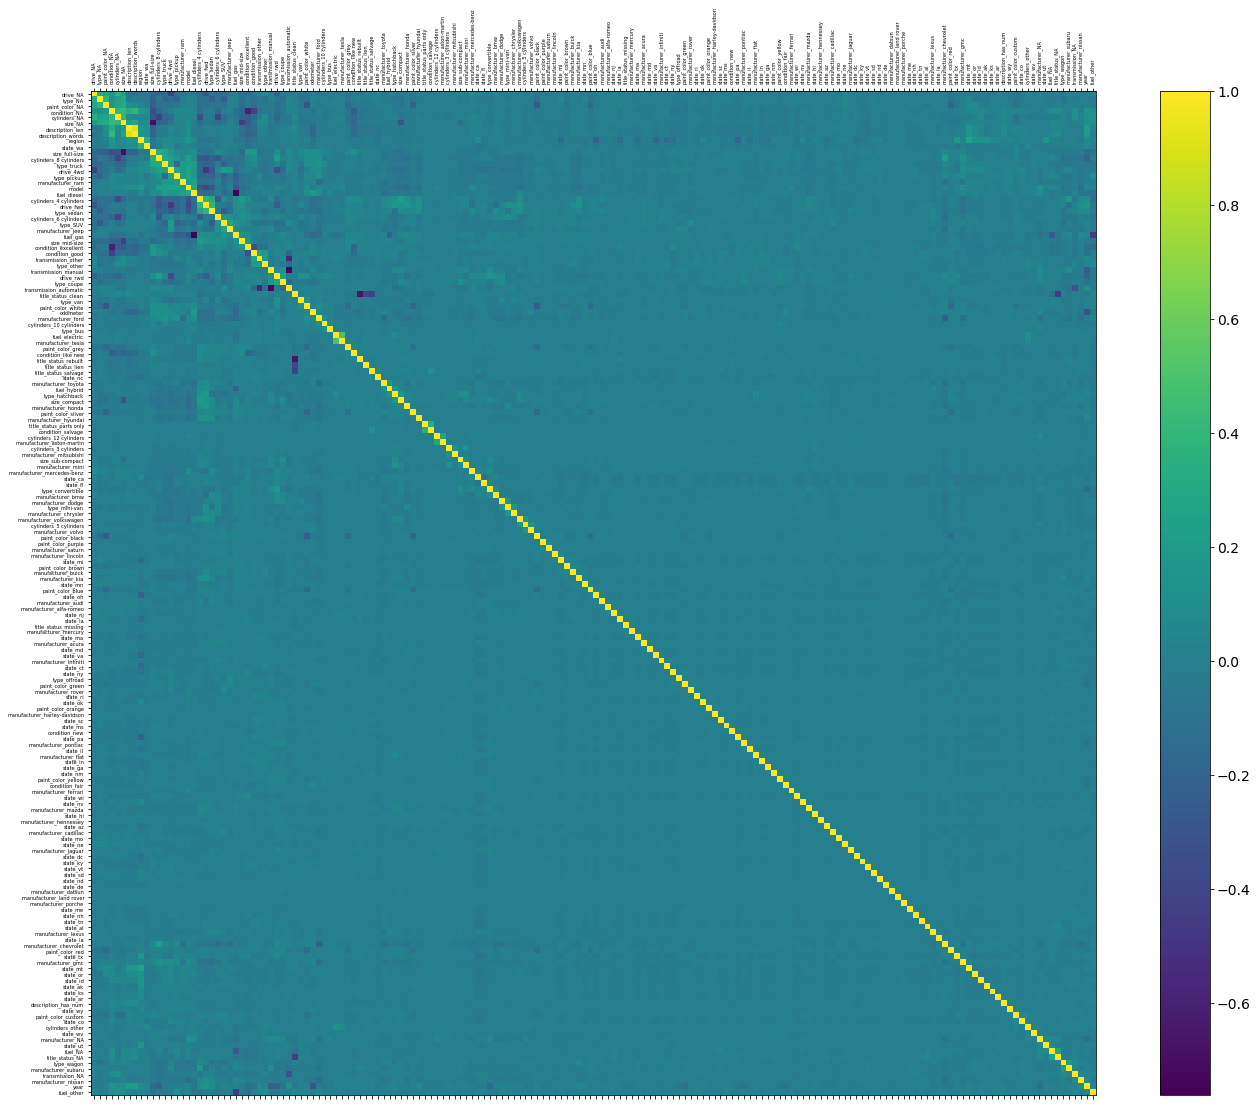

In [112]:
f = plt.figure(figsize=(23, 18))
plt.matshow(cov, fignum=f.number)
plt.xticks(range(len(feature_names)), feature_names, fontsize=5, rotation=90)
plt.yticks(range(len(feature_names)), feature_names, fontsize=5)
plt.clim(np.amin(cov),np.amax(cov))
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

From this plot, four of the prominent clusters of covariance plotted on the same color scale are:

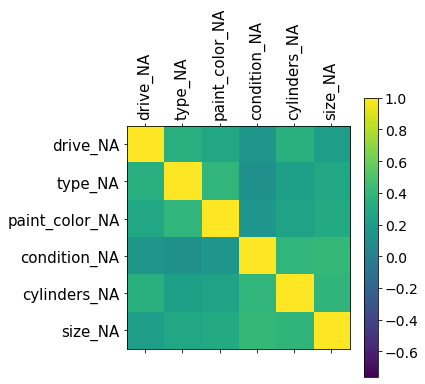

In [114]:
f = plt.figure(figsize=(5,5))
plt.matshow(cov[0:6,0:6], fignum=f.number)
plt.xticks(range(len(feature_names[0:6])), feature_names[0:6], fontsize=15, rotation=90)
plt.yticks(range(len(feature_names[0:6])), feature_names[0:6], fontsize=15)
cb = plt.colorbar()
plt.clim(np.amin(cov),np.amax(cov))
cb.ax.tick_params(labelsize=14)

The empty ("NA") categorical variables seem to have high covariance which makes sense. 

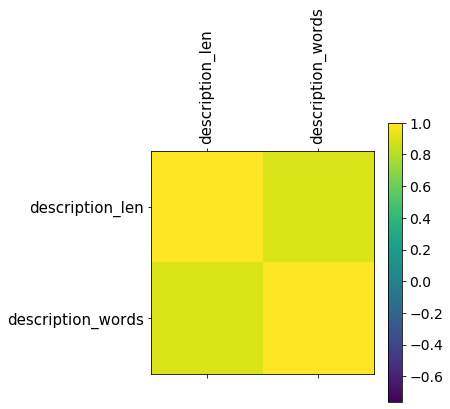

In [116]:
f = plt.figure(figsize=(5,5))
plt.matshow(cov[6:8,6:8], fignum=f.number)
plt.xticks(range(len(feature_names[6:8])), feature_names[6:8], fontsize=15, rotation=90)
plt.yticks(range(len(feature_names[6:8])), feature_names[6:8], fontsize=15)
cb = plt.colorbar()
plt.clim(np.amin(cov),np.amax(cov))
cb.ax.tick_params(labelsize=14)

There a strong correlation between the features we engineered of description length and description word count

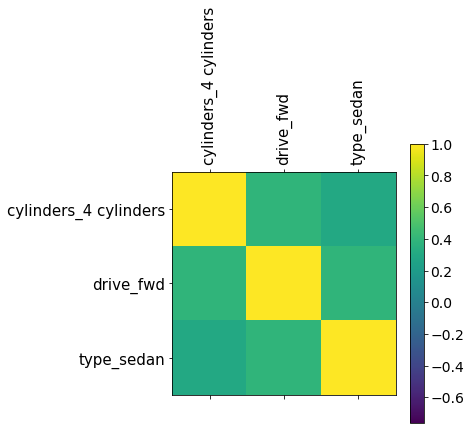

In [119]:
f = plt.figure(figsize=(5,5))
plt.matshow(cov[18:21,18:21], fignum=f.number)
plt.xticks(range(len(feature_names[18:21])), feature_names[18:21], fontsize=15, rotation=90)
plt.yticks(range(len(feature_names[18:21])), feature_names[18:21], fontsize=15)
cb = plt.colorbar()
plt.clim(np.amin(cov),np.amax(cov))
cb.ax.tick_params(labelsize=14)

There are also seems to be a covariance between 4_cylinders, front-wheel drive, and sedans which also makes sense

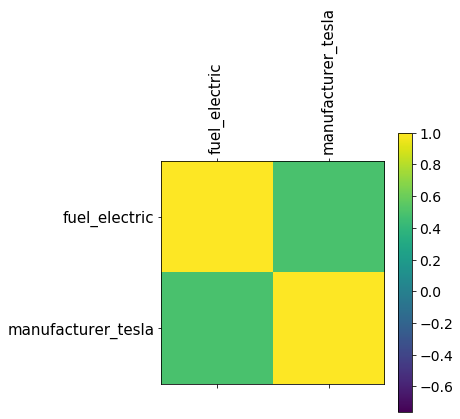

In [129]:
f = plt.figure(figsize=(5,5))
plt.matshow(cov[41:43, 41:43], fignum=f.number)
plt.xticks(range(len(feature_names[41:43])), feature_names[41:43], fontsize=15, rotation=90)
plt.yticks(range(len(feature_names[41:43])), feature_names[41:43], fontsize=15)
cb = plt.colorbar()
plt.clim(np.amin(cov),np.amax(cov))
cb.ax.tick_params(labelsize=14)

There's also a strong correlation between electric cars and the manufacturer Tesla which also makes a lot of sense. Given that most of these clusters are between different values of various one-hot-encoded variables we won't be removing any features for the ensuing analysis.

## Task 4: Any model
Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate.

#### SGDRegressor (Stochastic Gradient Descent)

In [71]:
model_SGD_regression = make_pipeline(preprocess, SGDRegressor())

In [72]:
scores = cross_val_score(model_SGD_regression, X_train, y_train)
np.mean(scores)

-2.42945138221193e+25

#### DecisionTreeRegressor

model_tree_regression = make_pipeline(preprocess, DecisionTreeRegressor())

In [282]:
scores = cross_val_score(model_tree_regression, X_train, y_train)
np.mean(scores)

0.5383539697832583

#### RandomForestRegressor

In [75]:
model_rf_regression = make_pipeline(preprocess, RandomForestRegressor(n_estimators=10, max_depth=20))

In [76]:
scores = cross_val_score(model_rf_regression, X_train, y_train)
np.mean(scores)

0.7392246228020956

#### LinearSVR

In [77]:
model_linearsvr_regression = make_pipeline(preprocess, LinearSVR(dual=False, loss='squared_epsilon_insensitive'))

In [78]:
scores = cross_val_score(model_linearsvr_regression, X_train, y_train)
np.mean(scores)

0.3261955952930142

#### GradientBoostingRegressor

In [53]:
model_gradientboosting_regression = make_pipeline(preprocess, GradientBoostingRegressor(random_state = 1))

In [54]:
scores = cross_val_score(model_gradientboosting_regression, X_train, y_train)
np.mean(scores)

0.6674138607353213

#### HistGradientBoostingRegressor

In [49]:
model_histgradientboosting_regression = make_pipeline(preprocess, FunctionTransformer(lambda x: x.todense(), accept_sparse=True), HistGradientBoostingRegressor())


In [50]:
scores = cross_val_score(model_histgradientboosting_regression, X_train, y_train)
np.mean(scores)

0.7218209563380812

Of all these models, the RandomForestRegressor performed the best and the HistGradientBoostingRegressor performed next best but was significantly faster. However, the HistGradientBoostingRegressor is a experimental model and so a lot of feature selection matrices cannot be used, so we decide to use the regular gradient boosting model for the rest of this section.

In [55]:
pipe = Pipeline([('preprocessor', preprocess),('regressor', GradientBoostingRegressor(warm_start=True, random_state = 1))])
param_grid = [
    {'regressor': [GradientBoostingRegressor(warm_start=True, random_state = 1)],
    'regressor__learning_rate': [0.05,0.1, 0.2,0.3,0.4],
    'regressor__n_estimators': [100,200,300,400]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)  
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('iterativeimputer',
                                                                                          IterativeImputer(add_indicator=False,
                                                                                                           estimator=LinearRegressio

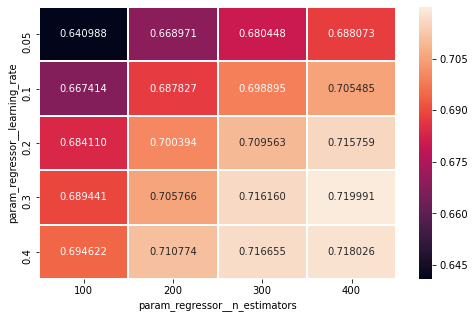

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_grid = pd.DataFrame(grid.cv_results_).round(6)
df_grid
res = pd.pivot_table(df_grid,
    values='mean_test_score', index='param_regressor__learning_rate', columns='param_regressor__n_estimators')
ax = sns.heatmap(res, annot=True, linewidths=1, fmt="f")

In [59]:
grid.score(X_test, y_test)

0.7547639372656195

With a grid search over the learning_rate and n_estimators params we were able to fine-tune the GradientBoosting model to increase it's training score from 0.667 to 0.7199

#### Trying out random search for the gradient boosting model

In [100]:
pipe_random = Pipeline([('preprocessor', preprocess),('regressor', GradientBoostingRegressor(warm_start=True, random_state = 1))])
param_dist = [
    {'regressor': [GradientBoostingRegressor(warm_start=True, random_state = 1)],
     'regressor__learning_rate': [0.2,0.3,0.4],
     'regressor__n_estimators': [300,400],
     'regressor__max_depth': [3, 15],
     'regressor__max_features': randint(1, 11),
     'regressor__min_samples_split': randint(2, 11),
     'regressor__min_samples_leaf': randint(1, 11)
    }
]

random_search = RandomizedSearchCV(pipe_random, param_distributions=param_dist, n_iter=10, cv=5, return_train_score=True, random_state = 1)  
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('iterativeimputer',
                                                                                                IterativeImputer(add_indicator=False,
                                                                  

In [101]:
random_search.score(X_test, y_test)

0.787222420748868

The params from our Random Search further improved our test score so we'll use these params for the remaining analysis in section five

In [102]:
random_search.best_params_

{'regressor': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.2, loss='ls', max_depth=15,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=9, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True),
 'regressor__learning_rate': 0.2,
 'regressor__max_depth': 15,
 'regressor__max_features': 9,
 'regressor__min_samples_leaf': 9,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 400}

## Task 5: Feature Selections

Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better? (This will be discussed in the lecture on 03/04).

### Select 50 Best

In [121]:
best_gb_regressor = GradientBoostingRegressor(learning_rate=0.2, n_estimators=400, max_features=9, min_samples_leaf=9, min_samples_split=5, max_depth=15, random_state=1)

In [122]:
model_gradientboosting_regression = make_pipeline(preprocess, SelectKBest(k=50, score_func=f_regression), best_gb_regressor)


In [123]:
model_gradientboosting_regression.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [124]:
model_gradientboosting_regression.score(X_test,y_test)

0.7758656554097578

Using the 50 best features our test score went down a little bit

### Select feature using the RidgeCV model

In [ ]:
best_gb_regressor_lasso_cv = GradientBoostingRegressor(learning_rate=0.2, n_estimators=400, max_features=9, min_samples_leaf=9, min_samples_split=5, max_depth=15, random_state=1)



In [130]:
model_gradientboosting_regression = make_pipeline(preprocess, SelectFromModel(RidgeCV(), threshold=1e-5), best_gb_regressor)


In [131]:
model_gradientboosting_regression.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [132]:
model_gradientboosting_regression.score(X_test,y_test)

0.787222420748868

Here we see the features selected by our RidgeCV model

In [133]:
selected_feature_idx = model_gradientboosting_regression.steps[1][1].get_support()
feature_name_scalar = np.array(feature_name)
feature_name_scalar[selected_feature_idx]

array(['year', 'odometer', 'description_words', 'description_has_num',
       'description_len', 'region', 'model', 'cylinders_10 cylinders',
       'cylinders_12 cylinders', 'cylinders_3 cylinders',
       'cylinders_4 cylinders', 'cylinders_5 cylinders',
       'cylinders_6 cylinders', 'cylinders_8 cylinders', 'cylinders_NA',
       'cylinders_other', 'fuel_NA', 'fuel_diesel', 'fuel_electric',
       'fuel_gas', 'fuel_hybrid', 'fuel_other', 'title_status_NA',
       'title_status_clean', 'title_status_lien', 'title_status_missing',
       'title_status_parts only', 'title_status_rebuilt',
       'title_status_salvage', 'transmission_NA',
       'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_NA', 'drive_fwd',
       'drive_rwd', 'size_NA', 'size_compact', 'size_full-size',
       'size_mid-size', 'size_sub-compact', 'type_NA', 'type_SUV',
       'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback',
       'type_mini-van', 't

In [134]:
feature_name_scalar[~selected_feature_idx]

array([], dtype='<U28')

So the RidgeCV model selected everything, which makes sense given the identical score to the RandomSearch

### Recursive Feature Elimination

In [136]:
model_gradientboosting_regression = make_pipeline(preprocess, RFECV(LinearRegression(), cv=10), best_gb_regressor)
model_gradientboosting_regression.fit(X_train,y_train)
model_gradientboosting_regression.score(X_test,y_test)

0.787222420748868

Similarly, Recursive Feature Elimination used all the features and gave an identical score to our best model

### Feature Importance

Let's explore the top 10 and bottom 10 most important features

In [137]:
model_gradientboosting_regression = make_pipeline(preprocess, best_gb_regressor)

In [138]:
model_gradientboosting_regression.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [139]:
model_gradientboosting_regression.score(X_test,y_test)

0.787222420748868

In [140]:
regressor = model_gradientboosting_regression.steps[1][1]

In [141]:
best_tree_importance_sorted_idx = np.argsort(regressor.feature_importances_)[-10:]
tree_indices = np.arange(0, 10) + 0.5

In [142]:
train_feature_names_regular = [feature_name[i] for i in best_tree_importance_sorted_idx]

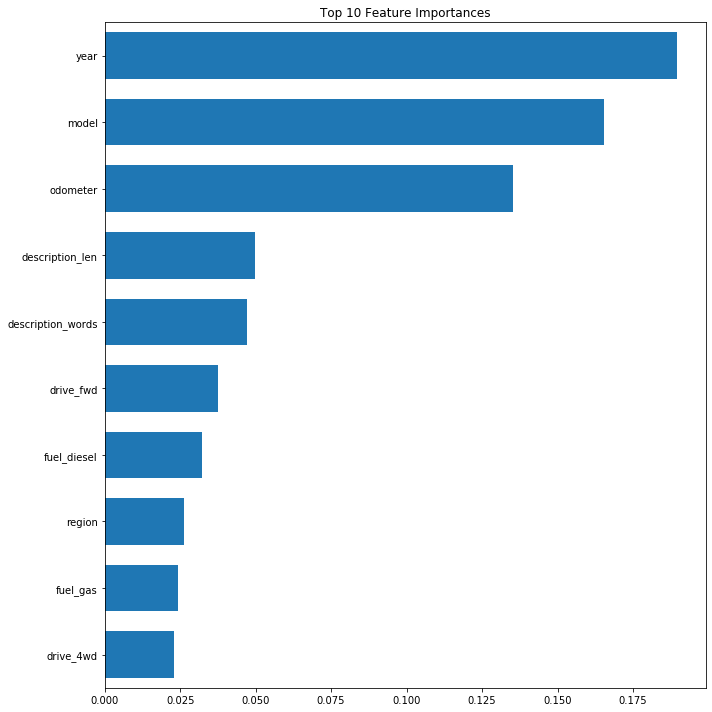

In [143]:
fig = plt.figure(figsize=(10, 10))
plt.barh(tree_indices,
         regressor.feature_importances_[best_tree_importance_sorted_idx], 
         height=0.7,
         tick_label=train_feature_names_regular)
plt.yticks(tree_indices)
plt.ylim((0, 10))
plt.title("Top 10 Feature Importances")
fig.tight_layout()
plt.show()

In [144]:
worst_tree_importance_sorted_idx = np.argsort(regressor.feature_importances_)[:10]
tree_indices = np.arange(0, 10) + 0.5

train_feature_names_regular = [feature_name[i] for i in worst_tree_importance_sorted_idx]

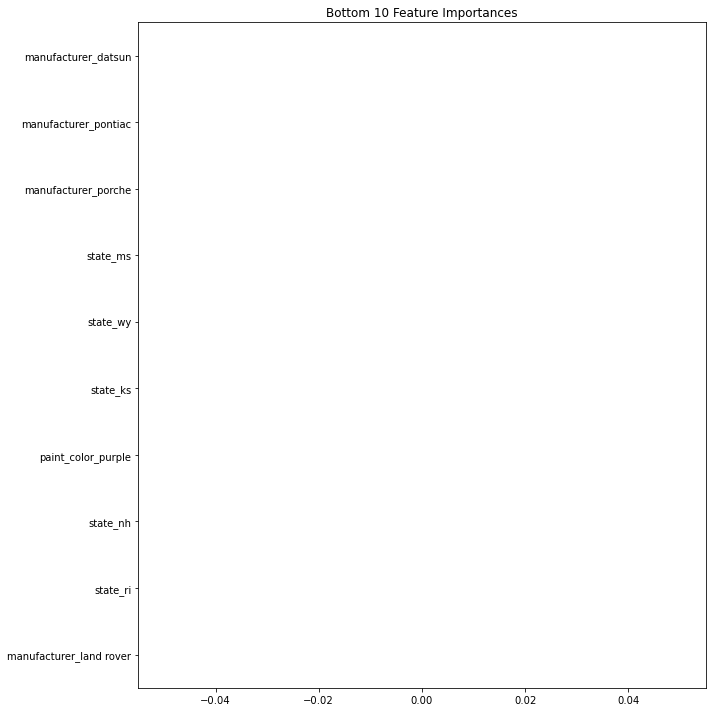

In [236]:
fig = plt.figure(figsize=(10, 10))
plt.barh(tree_indices,
         regressor.feature_importances_[worst_tree_importance_sorted_idx], 
         height=0.7,
         tick_label=train_feature_names_regular)
plt.yticks(tree_indices)
plt.ylim((0, 10))
plt.title("Bottom 10 Feature Importances")
fig.tight_layout()
plt.show()

### Permutation Importance

Let's visualize the permutation importance of our columns 

In [146]:
train_result = permutation_importance(model_gradientboosting_regression, X_train, y_train, n_repeats=10, random_state=1)

In [147]:
boosting_feature_names = X_train.columns.tolist()

In [150]:
train_perm_sorted_idx = train_result.importances_mean.argsort()

In [151]:
train_feature_names_permutation = [boosting_feature_names[i] for i in train_perm_sorted_idx]

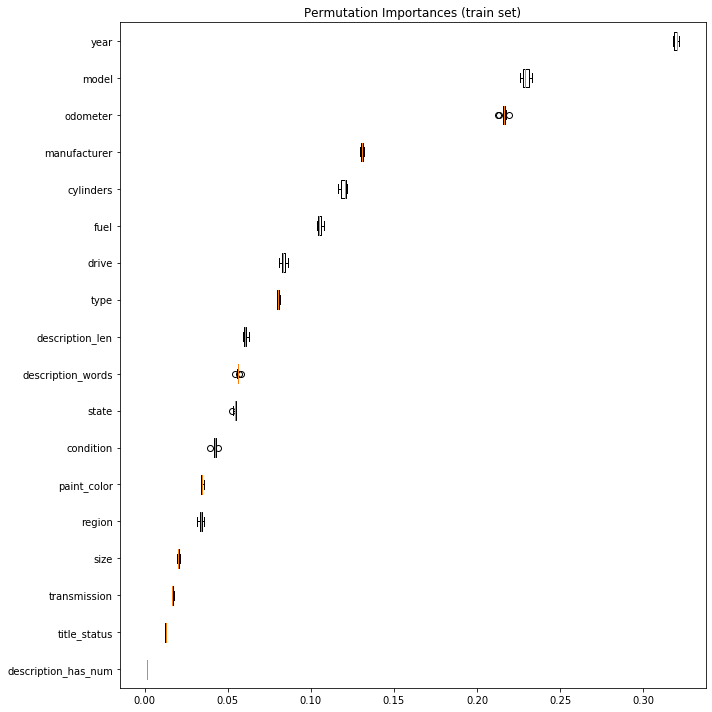

In [152]:
fig = plt.figure(figsize=(10, 10))
plt.boxplot(train_result.importances[train_perm_sorted_idx].T, vert=False,
            labels=train_feature_names_permutation)
plt.title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [153]:
test_result = permutation_importance(model_gradientboosting_regression, X_test, y_test, n_repeats=10, random_state=1)

In [154]:
test_perm_sorted_idx = test_result.importances_mean.argsort()

In [155]:
test_feature_names = [boosting_feature_names[i] for i in test_perm_sorted_idx]

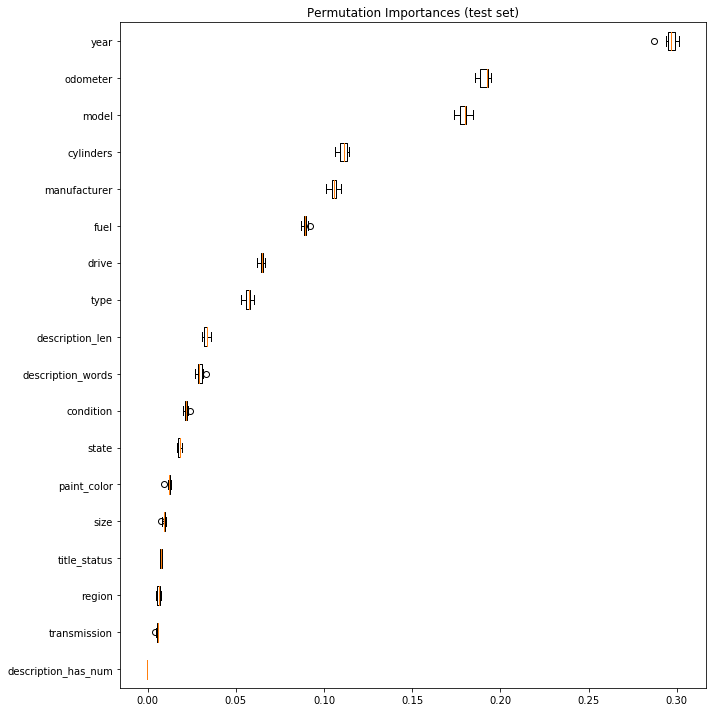

In [156]:
fig = plt.figure(figsize=(10, 10))
plt.boxplot(test_result.importances[test_perm_sorted_idx].T, vert=False,
            labels=test_feature_names)
plt.title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

According to our permutation importancce graphs for both the training and test data, the most important feature was the **year** for our Gradient Boosting Model. The top five most important features were the same **(year, odometer, model, cylinders, manufacturer)**, although the order was different. Our custom **description_has_num param** was the least useful. Removing it would probably not affect our model. Size was also low on the permutation graphs - perhaps because 67% of the values were missing.

### Partial Dependence

Now let's explore the partial dependence plots of our features

In [158]:
X_process = preprocess.fit_transform(X_train, y_train)

In [159]:
gbrt = best_gb_regressor

In [160]:
gbrt.fit(X_process, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=15,
                          max_features=9, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [161]:
continuous_feature_name = X_train.columns[~categorical].tolist()
target_feature_name = model_linear_regression.steps[0][1].transformers_[1][2]
dummy_feature_name = model_linear_regression.steps[0][1].transformers_[2][1].steps[1][1].get_feature_names(['cylinders','fuel','title_status','transmission','drive','size','type','paint_color','manufacturer','state','condition']).tolist()
feature_name = continuous_feature_name + target_feature_name + dummy_feature_name

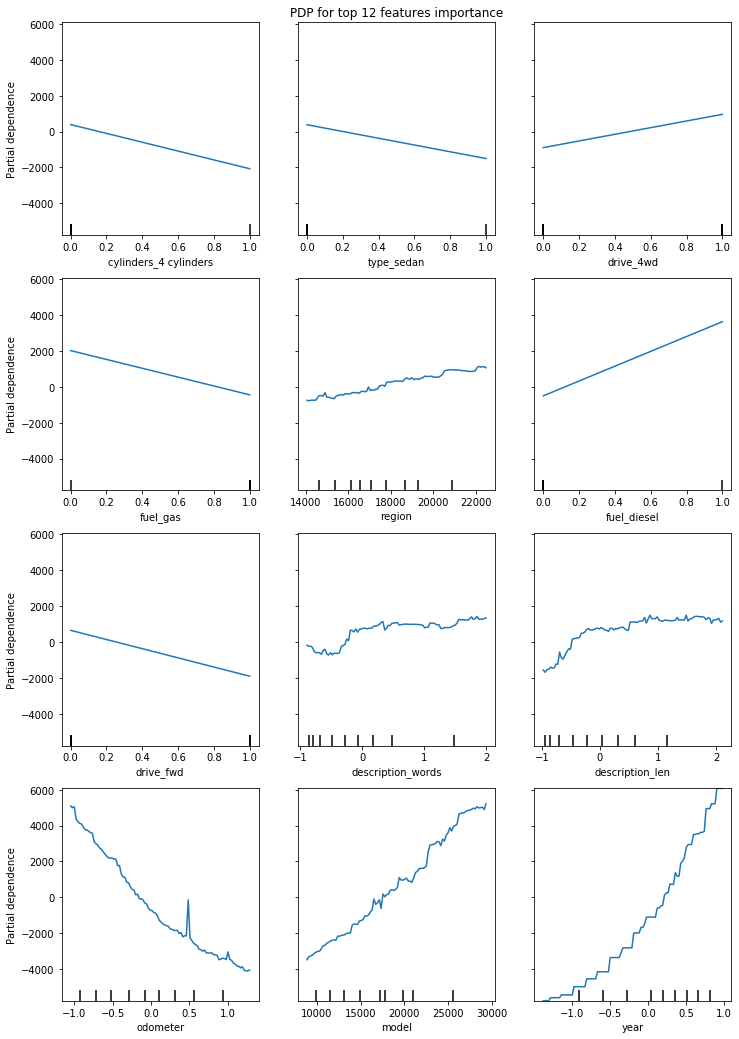

In [162]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.set_title("PDP for top 12 features importance")
plot_partial_dependence(gbrt, X_process.toarray(), np.argsort(gbrt.feature_importances_)[-12:], feature_names=feature_name, ax = ax)

Three standouts from our partial dependence plots are the **odometer, model, and year**. The price seems to drop as the odometer reading increase. On the opposite end, the price seems to increase as the cars release year increase. Finally, for the model, we see that the price increases as the average price (using target encoding) for each model increases. 

We also observed that some of our our one-hot encoded categorical features were helpful as well. For example, cars with **fuel_diesel** seem to have higher prices while cars with **fuel_gas** have lower prices. Similarly, four-wheel drive (**drive_4w**) cars seem to have prices prices as well.

## Task 6 An explainable model (Linear Model)
Can you create an “explainable” model that is nearly as good as your best model?
An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves etc.

In [116]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [117]:
all_coef = model_linear_regression.steps[1][1].coef_

In [64]:
continuous_feature_name = X_train.columns[~categorical].tolist()

In [65]:
continuous_feature_name

['year',
 'odometer',
 'description_len',
 'description_words',
 'description_has_num']

In [66]:
target_feature_name = model_linear_regression.steps[0][1].transformers_[1][2]

In [67]:
dummy_feature_name = model_linear_regression.steps[0][1].transformers_[2][1].steps[1][1].get_feature_names(['cylinders','fuel','title_status','transmission','drive','size','type','paint_color','manufacturer','state','condition']).tolist()

In [68]:
feature_name = continuous_feature_name + target_feature_name + dummy_feature_name

In [123]:
len(feature_name) == len(all_coef)

True

In [177]:
np.argsort(abs(all_coef))

array([  5,   6, 126,  50,   3, 164,  23, 121,  65, 128, 154,  22,  38,
        39,  21,  48, 122, 162,  67, 149, 117, 135, 160, 129, 152,  60,
        34, 134,  51,  49,  61, 138, 115, 156, 127, 155,  54, 144, 140,
        68, 141,  57,  53,   4, 146, 119, 139, 113, 157, 163, 102, 105,
       137, 124, 145,   2,  59,  79,  42,  58, 142, 133,  94,  20, 136,
        98, 148,  37,  62,  36,  56, 120, 131, 132, 143, 150, 159, 116,
        30,  66, 114,  29,  40, 147,  32, 125,  76, 158, 118,  26, 130,
        43, 103,  64,  93,  52,  13,  16,  70, 166, 111, 112, 109,  19,
       151,  41,   7,  97,  35,  55, 153,  46,  15,  47, 123,  87,  90,
        33,  63,  84,  69,  14, 161,  95,  71, 106,  77,  44,  31,  12,
       165,  24, 167,  89,  18,  78,  83,  75,  45,  27,   0,  74,  91,
         1,  73,  80, 104, 101,  86, 107,  92,  10, 169,  88,  28,  99,
        96, 100, 168, 110,  85,  25,  11,  17,   9, 108,  82,  72,   8,
        81])

In [178]:
important = np.argsort(abs(all_coef))[-10:]

In [179]:
not_important = np.argsort(abs(all_coef))[:10]

In [180]:
top10_feature = [feature_name[i] for i in important]
top10_coef = [all_coef[i] for i in important]

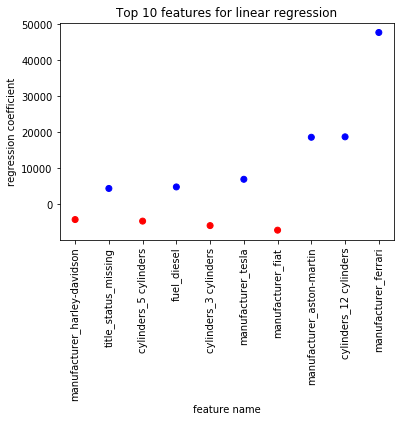

In [181]:
plt.scatter(top10_feature, top10_coef, c=np.sign(top10_coef), cmap='bwr_r')
plt.xticks(rotation='vertical')
plt.xlabel("feature name")
plt.ylabel("regression coefficient")
plt.title("Top 10 features for linear regression")
plt.show()

In [146]:
bottom10_feature = [feature_name[i] for i in not_important]
bottom10_coef = [all_coef[i] for i in not_important]

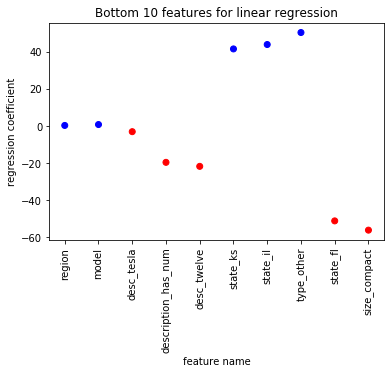

In [147]:
plt.scatter(bottom10_feature, bottom10_coef, c=np.sign(bottom10_coef), cmap='bwr_r')
plt.xticks(rotation='vertical')
plt.xlabel("feature name")
plt.ylabel("regression coefficient")
plt.title("Bottom 10 features for linear regression")
plt.show()

In [167]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [168]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [169]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.5201406700542973

In [170]:
model_linear_regression.score(X_test, y_test)

0.5282310575845035

### Select 10 best from linear model

In [171]:
model_linear_regression = make_pipeline(preprocess, SelectKBest(k=10, score_func=f_regression), LinearRegression())

In [172]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [173]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.4823195418837735

In [177]:
model_linear_regression.score(X_test, y_test)

0.4815001045434626

In [174]:
selected_feature_idx = model_linear_regression.steps[1][1].get_support()

In [175]:
feature_name_scalar = np.array(feature_name)

In [176]:
feature_name_scalar[selected_feature_idx]

array(['year', 'odometer', 'description_len', 'region', 'model',
       'cylinders_4 cylinders', 'fuel_diesel', 'fuel_gas', 'drive_4wd',
       'drive_fwd'], dtype='<U28')

### We'll try an elastic net model as well

In [181]:
from sklearn.exceptions import ConvergenceWarning
import warnings

**NOTE:** The ElasticNet regression threw multiple convergence warnings when training. In the spirit of running without filling these notebook with red warnings that make it hard to read, I'm surpressing warnings for the training of these models. 

In [308]:
with warnings.catch_warnings(record=True) as w:
    pipe_elastic = Pipeline([('preprocessor', preprocess),('regressor', ElasticNet(random_state=1))])
    param_grid_elastic = [
        {'regressor': [ElasticNet(max_iter=200, random_state=1)],
        'regressor__alpha': np.logspace(-7, -1, 7),
        'regressor__l1_ratio': [.5, .8, .9, .95, .98, 1],
        }
    ]

    grid_elastic = GridSearchCV(pipe_elastic, param_grid_elastic, cv=5, return_train_score=True)  
    grid_elastic.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('iterativeimputer',
                                                                                          IterativeImputer(add_indicator=False,
                                                                                                           estimator=LinearRegressio

In [309]:
grid_elastic.score(X_test, y_test)

0.5277904021235292

In [310]:
grid_elastic.cv_results_

{'mean_fit_time': array([ 5.44154329,  6.54290204,  9.14457049,  8.4904027 ,  8.90679426,
         9.19855661,  9.03157487,  8.89158225,  9.65002198, 13.63813782,
        16.38514581, 15.81931119, 11.24986029, 15.18856425, 11.00079808,
         8.86817532, 12.07924376, 13.54318457,  8.04076219, 10.46483459,
        12.48180213, 10.23365765, 10.87715173, 10.30448256,  8.03962021,
         5.97593861,  6.59904232,  5.78265586,  7.16692157, 12.22297559,
         8.07246413,  6.84349747,  6.23855948,  6.13751822,  6.34808426,
         9.29498272,  2.51266713,  3.11659427,  5.13615384,  7.45398321,
         7.37231984,  7.20355392]),
 'std_fit_time': array([0.09520224, 0.93060866, 0.16764847, 0.14919645, 0.27160961,
        0.12569457, 0.21212399, 0.02962843, 0.37700902, 1.99868134,
        1.85168144, 1.77338053, 0.22715775, 2.79268072, 1.97381793,
        0.47337183, 0.96262682, 1.12867891, 0.57401635, 1.49743131,
        1.02166966, 0.4429031 , 0.20909155, 0.26324205, 1.37659725,
       

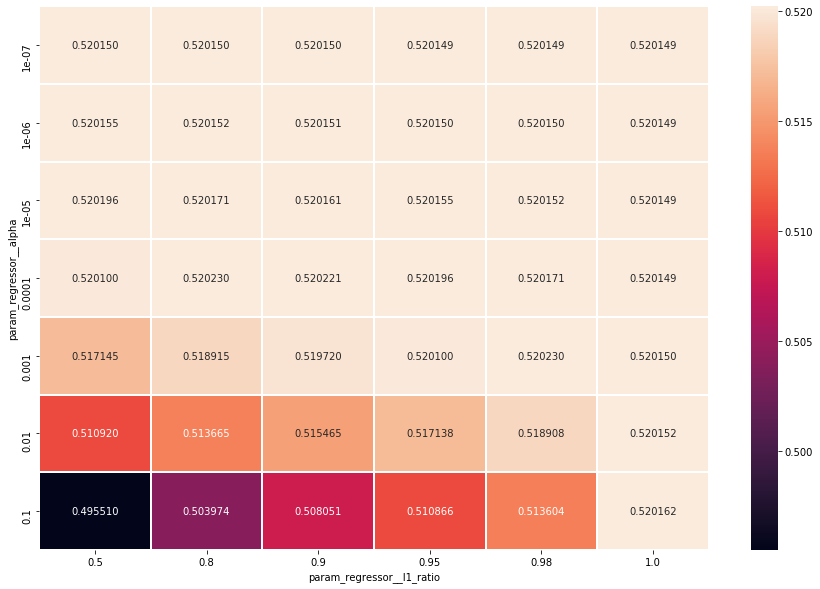

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df_grid = pd.DataFrame(grid_elastic.cv_results_).round(6)
df_grid
res = pd.pivot_table(df_grid,
    values='mean_test_score', index='param_regressor__alpha', columns='param_regressor__l1_ratio')
ax = sns.heatmap(res, annot=True, linewidths=1, fmt="f")

In [313]:
grid_elastic.best_params_

{'regressor': ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.8,
            max_iter=200, normalize=False, positive=False, precompute=False,
            random_state=1, selection='cyclic', tol=0.0001, warm_start=False),
 'regressor__alpha': 0.0001,
 'regressor__l1_ratio': 0.8}

In [314]:
model_best_elasticnet = make_pipeline(preprocess, ElasticNet(alpha=0.0001, l1_ratio=0.8, random_state=1))

In [315]:
model_best_elasticnet.fit(X_train, y_train)

/Users/emjoseph/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2160532765554.232, tolerance: 1049956562.9820063
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [316]:
model_best_elasticnet.score(X_test, y_test)

0.5277927926028776

In [317]:
all_coef = model_best_elasticnet.steps[1][1].coef_

In [318]:
len(feature_name) == len(all_coef)

True

In [319]:
np.argsort(abs(all_coef))

array([  5,  36,   6, 164,  67,  13,  22,  54, 126,   3, 121, 154,  23,
        53,  51, 128,  39, 122,  61, 149, 162, 135, 129,  68, 117,  94,
        42, 134,  65, 160, 138,  38, 152,  20, 115, 156,  15, 155, 127,
       119,  60, 144,  50,  59, 141, 146,   4,  48, 140,  58, 139, 157,
        21, 113,  37,  76,  62, 124, 163,   2, 137,  57,  56, 145, 133,
       142,  49, 143, 132, 131, 148,  66, 136, 150,  40, 159, 116,  98,
        43, 105, 114, 147, 102,  35, 125,  14,  16,  34,  70,  52, 120,
       158, 109, 118,  19,  97,  64, 130,  30,  29,  55,  12,  32,  79,
       166,  87,  47,  90, 112, 151,  26, 153,  84,  41, 111, 123,  95,
        46, 106,  18,  77,  31,  63, 161,  89,  71,  78,  75,  83, 165,
        24,  69,  33,  44, 167,   7,  10,  27,  74,  91,  73,  93,  45,
       169,  80,   0, 104, 101,   1, 107,  92,  88,  99, 103,  96,  28,
       100,  85, 110,  11, 168,   9,  17,  25,  82, 108,  86,   8,  72,
        81])

In [320]:
important = np.argsort(abs(all_coef))[-10:]

In [321]:
not_important = np.argsort(abs(all_coef))[:10]

In [322]:
top10_feature = [feature_name[i] for i in important]
top10_coef = [all_coef[i] for i in important]

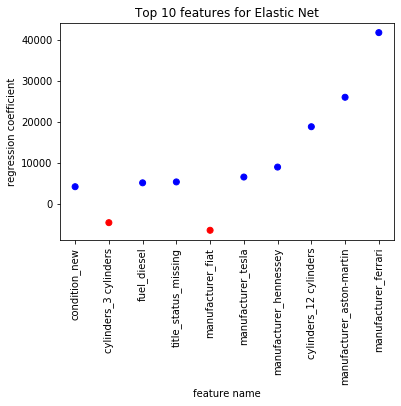

In [323]:
plt.scatter(top10_feature, top10_coef, c=np.sign(top10_coef), cmap='bwr_r')
plt.xticks(rotation='vertical')
plt.xlabel("feature name")
plt.ylabel("regression coefficient")
plt.title("Top 10 features for Elastic Net")
plt.show()

In [324]:
bottom10_feature = [feature_name[i] for i in not_important]
bottom10_coef = [all_coef[i] for i in not_important]

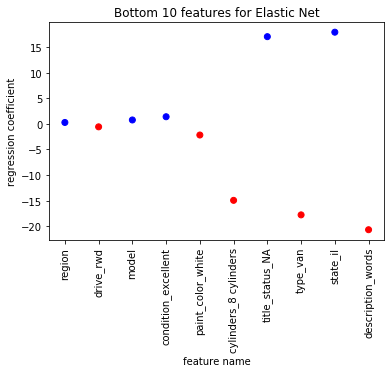

In [325]:
plt.scatter(bottom10_feature, bottom10_coef, c=np.sign(bottom10_coef), cmap='bwr_r')
plt.xticks(rotation='vertical')
plt.xlabel("feature name")
plt.ylabel("regression coefficient")
plt.title("Bottom 10 features for Elastic Net")
plt.show()

Overall, our simplest best performing linear model had a test score of 0.53. The ElasticNet model did no better than our simple linear model. We were able to simplify the linear model by only considering the top 10 features which only reduced the test score down to 0.48. 

The Aston Martin, Ferrari, and Tesla manufacturers were the three of the top positive regression coefficients, while the Fiat manufacturer was one of the top negative regression coefficients. Having 12 cylinders was also one of the top positive regression ccoefficients while having 3 cylinders was one of the top negative regression coefficients.

The top 10 features selected by the SelectKBest functionality were 'year', 'odometer', 'description_len', 'region', 'model','cylinders_4 cylinders', 'fuel_diesel', 'fuel_gas', 'drive_4wd', and 'drive_fwd'

## Task 6: An explainable model (Tree Model)
Can you create an “explainable” model that is nearly as good as your best model?
An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves etc.

Let's try tuning a tree-based model with the max_depth and max_leaf_nodes params

In [327]:
pipe = Pipeline([('preprocessor', preprocess),('regressor', DecisionTreeRegressor())])
param_grid = [
    {'regressor': [DecisionTreeRegressor()],
    'regressor__max_depth': range(5, 8),
    'regressor__max_leaf_nodes': range(8, 16)
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)  
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('iterativeimputer',
                                                                                          IterativeImputer(add_indicator=False,
                                                                                                           estimator=LinearRegressio

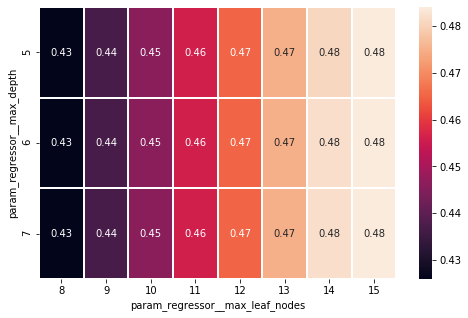

In [330]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_grid = pd.DataFrame(grid.cv_results_).round(3)
df_grid
res = pd.pivot_table(df_grid,
    values='mean_test_score', index='param_regressor__max_depth', columns='param_regressor__max_leaf_nodes')
ax = sns.heatmap(res, annot=True, linewidths=1)

In [331]:
grid.best_params_

{'regressor': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                       max_features=None, max_leaf_nodes=15,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'regressor__max_depth': 5,
 'regressor__max_leaf_nodes': 15}

Let's also try tuning this model using cost-complexity pruning using the best params from the previous search

In [335]:
pipe = Pipeline([('preprocessor', preprocess),('regressor', DecisionTreeRegressor(max_depth=5, max_leaf_nodes=15))])
param_grid = [
    {'regressor': [DecisionTreeRegressor(max_depth=5, max_leaf_nodes=15)],
    'regressor__ccp_alpha': np.linspace(0.,0.03,6),
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)  
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('iterativeimputer',
                                                                                          IterativeImputer(add_indicator=False,
                                                                                                           estimator=LinearRegressio

In [336]:
# Extract Grid Params
grid_params = np.asarray(grid.cv_results_['param_regressor__ccp_alpha']).astype(np.float64)
mean_test = np.asarray(grid.cv_results_['mean_test_score']).astype(np.float64)
std_test = np.asarray(grid.cv_results_['std_test_score']).astype(np.float64)
mean_train = np.asarray(grid.cv_results_['mean_train_score']).astype(np.float64)
std_train = np.asarray(grid.cv_results_['std_train_score']).astype(np.float64)

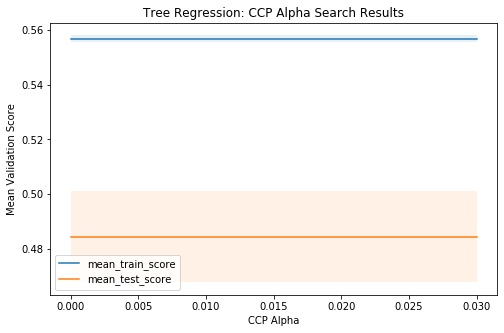

In [337]:
# Plot Grid Params (Ridge)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(grid_params, mean_train, label="mean_train_score")
ax.plot(grid_params, mean_test, label="mean_test_score")
ax.fill_between(grid_params, mean_train-std_train, mean_train+std_train, alpha=0.1)
ax.fill_between(grid_params, mean_test-std_test, mean_test+std_test, alpha=0.1)
ax.set_ylabel('Mean Validation Score')
ax.set_xlabel("CCP Alpha")
ax.set_title("Tree Regression: CCP Alpha Search Results")
ax.legend()

In [338]:
grid.best_params_

{'regressor': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                       max_features=None, max_leaf_nodes=15,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'regressor__ccp_alpha': 0.0}

In [73]:
model_tree_regression = make_pipeline(preprocess, DecisionTreeRegressor(max_depth=4, max_leaf_nodes=16))

In [74]:
model_tree_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [75]:
treeRegressor = model_tree_regression['decisiontreeregressor']

In [76]:
score = model_tree_regression.score(X_test, y_test)
print(score)

0.5011303801950775


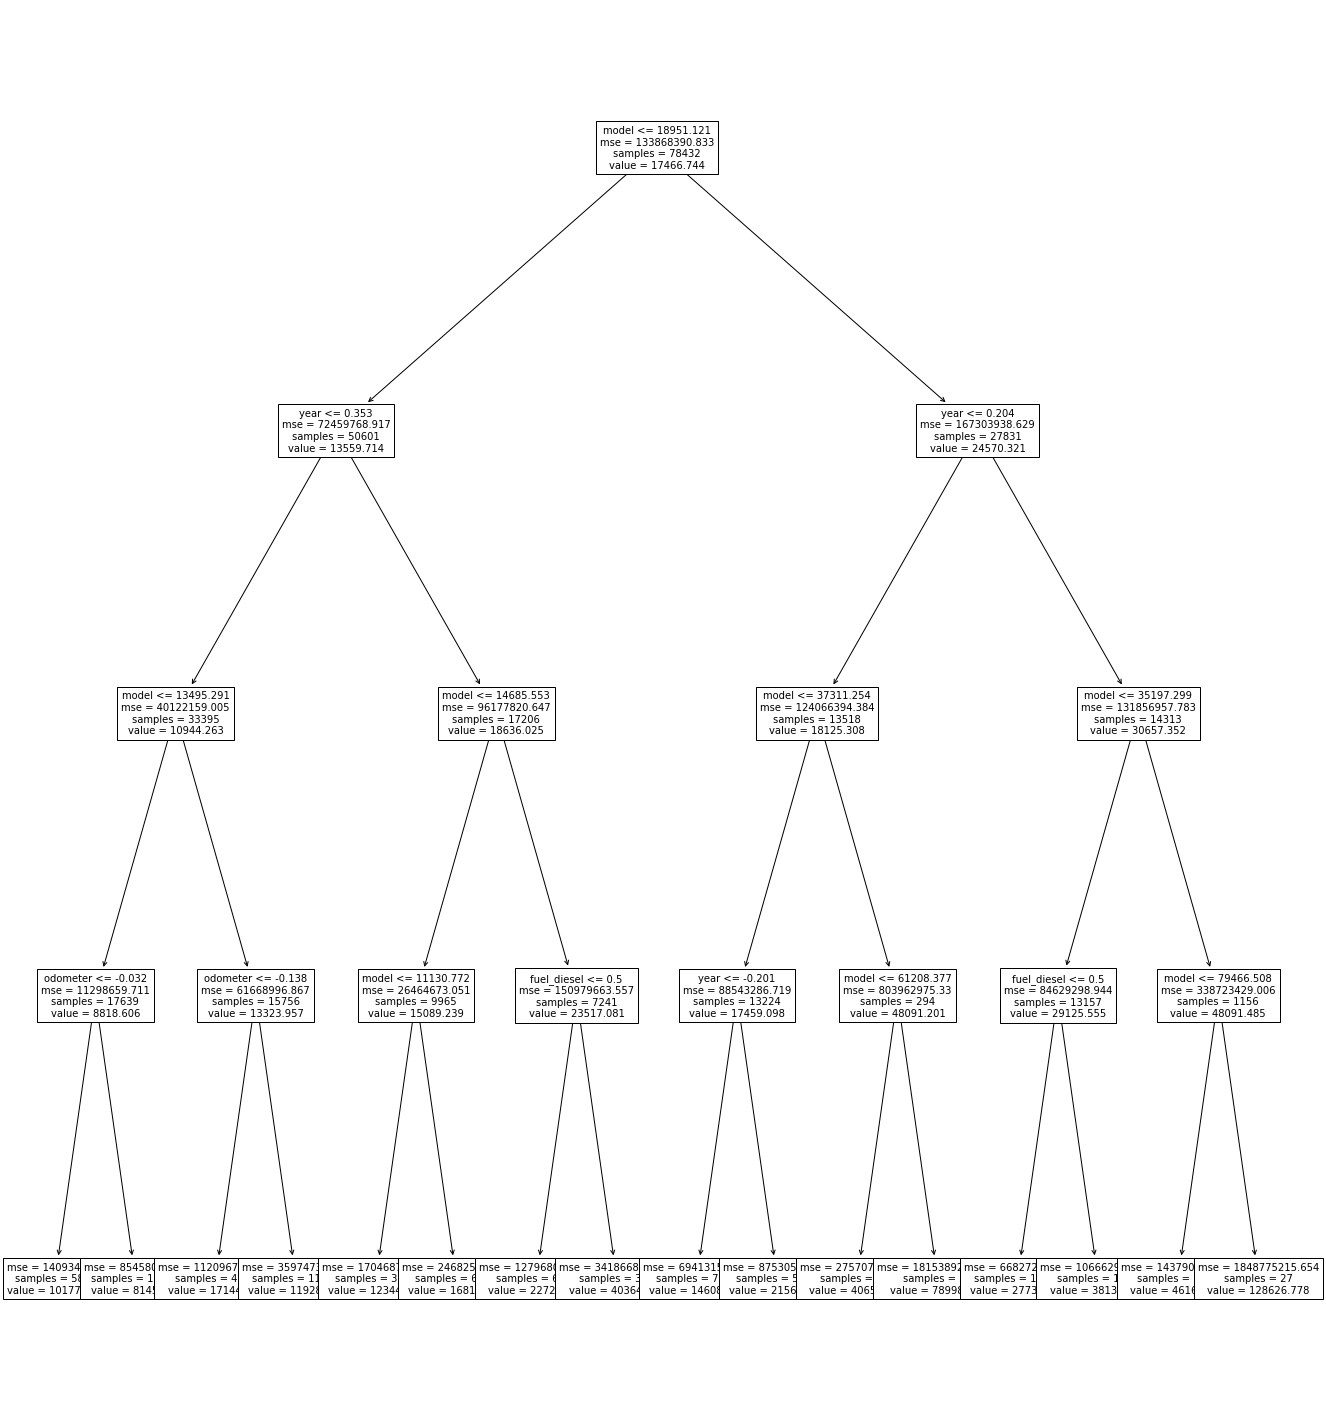

In [77]:
f = plt.figure(figsize=(23, 26))
tree_plot = plot_tree(treeRegressor, feature_names=feature_name, fontsize=10)

In [78]:
treeRegressor.feature_importances_
sorted_feature_indicies = np.flip(np.argsort(treeRegressor.feature_importances_))
sorted_features = np.flip(np.sort(treeRegressor.feature_importances_))
sorted_feature_names =  np.asarray(feature_name)[sorted_feature_indicies]

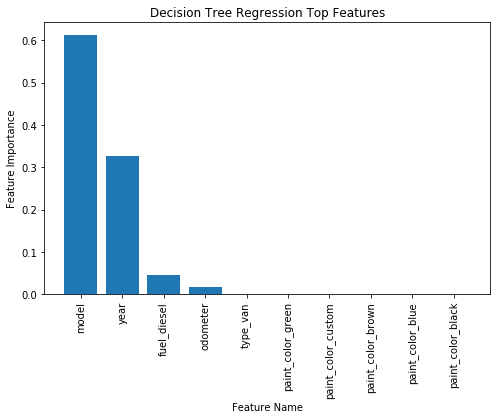

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(list(range(0,10)), sorted_features[0:10])
ax.set_ylabel('Feature Importance')
ax.set_xlabel("Feature Name")
ax.set_title("Decision Tree Regression Top Features")
ax.set_xticks(list(range(0,10)))
_ =ax.set_xticklabels(sorted_feature_names[0:10], rotation=90)

This simple tree model only uses 4 features (model, year, fuel, odometer) and has 15 leaf nodes with a max depth of 5. It had a test score of 0.50. To verify this, we'll retrain the model again adding SelectKBest to the pipeline which will eliminate all features except the four seen above and should get the same score.

In [96]:
model_tree_regression = make_pipeline(preprocess, SelectKBest(f_regression, k=4), DecisionTreeRegressor(max_depth=4, max_leaf_nodes=16))

In [97]:
model_tree_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('iterativeimputer',
                                                                   IterativeImputer(add_indicator=False,
                                                                                    estimator=LinearRegression(copy_X=True,
                                                                                                               fit_intercept=True,
                                                                                                               n_jobs=None,
                                                 

In [98]:
score = model_tree_regression.score(X_test, y_test)
print(score)

0.5011303801950775


The tree model performed just as well as our simplified linear model but with significantly fewer features. The most used feature in the branching of the tree was the target-encoded model column, followed by the year, the fuel_diesel one-hot column, and the odometer readings.